In [1]:
!pip install indic-transliteration
!pip install --upgrade indic-transliteration
import os
!pip install matplotlib
!pip install --upgrade indic-transliteration
# Disable wandb logging
os.environ['WANDB_MODE'] = 'disabled'
import os
import random
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import torch
import torch.nn.functional as F
from torch.optim import AdamW
import matplotlib.pyplot as plt  # For plotting

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification, 
    AutoModelForMaskedLM, 
    Trainer, 
    TrainingArguments, 
    TrainerCallback
)
from datasets import Dataset, ClassLabel, load_dataset
try:
    from indic_transliteration import sanscript
    from indic_transliteration.sanscript import transliterate
except ImportError:
    raise ImportError("Please install 'indic-transliteration' via 'pip install indic-transliteration'")
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 6.4 MB/s eta 0:00:00


2025-04-15 08:10:40.786972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744704641.057926      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744704641.135418      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class CustomTrainer(Trainer):
    """
    Custom Trainer to override compute_loss with focal_loss.
    """
    def compute_loss(self, model, inputs, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = focal_loss(logits, labels)
        if loss.dim() == 0:
            loss = loss.unsqueeze(0)
        if kwargs.get("return_outputs", False):
            return loss, outputs
        return loss

class LossCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.train_losses = []  # Avg training loss per epoch
        self.eval_losses = []   # Validation loss per epoch

    def on_epoch_end(self, args, state, control, **kwargs):
        if len(state.log_history) > 0 and "loss" in state.log_history[-1]:
            self.train_losses.append(state.log_history[-1]["loss"])

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if "eval_loss" in metrics:
            self.eval_losses.append(metrics["eval_loss"])

# Preprocessing

In [3]:
def convert_hinglish_to_hindi(text):
    if not text:
        return text
    count_devanagari = sum(1 for ch in text if '\u0900' <= ch <= '\u097F')
    ratio = count_devanagari / len(text)
    if ratio < 0.3:
        return transliterate(text, sanscript.ITRANS, sanscript.DEVANAGARI)
    else:
        return text
file_paths = {
    'en': {
        'train': '/kaggle/input/project-dataset/PROJECT DATASET/PROJECT DATASET/training/train_en_l1.csv',
        'test': '/kaggle/input/project-dataset/PROJECT DATASET/PROJECT DATASET/testing/test_en_l1.csv'
    },
    'hi': {
        'train': '/kaggle/input/project-dataset/PROJECT DATASET/PROJECT DATASET/training/train_hi_l1.csv',
        'test': '/kaggle/input/project-dataset/PROJECT DATASET/PROJECT DATASET/testing/test_hi_l1.csv'
    },
    'ta': {
        'train': '/kaggle/input/project-dataset/PROJECT DATASET/PROJECT DATASET/training/train_ta_l1.csv',
        'test': '/kaggle/input/project-dataset/PROJECT DATASET/PROJECT DATASET/testing/test_ta_l1.csv'
    }
}
def load_english_external_data():
    
    url = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"
    df_ext = pd.read_csv(url, engine='python')
    if "tweet" in df_ext.columns:
        df_ext = df_ext.rename(columns={"tweet": "text"})
    if "class" in df_ext.columns:
        df_ext["label"] = df_ext["class"].apply(lambda x: 1 if x == 0 else 0)
        df_ext = df_ext[["text", "label"]]
    for col in ["text", "label"]:
        if col not in df_ext.columns:
            raise ValueError(f"Column '{col}' missing in English external data.")
    return df_ext

# Paths to external Hindi and Tamil data
hindi_ext_path = "/kaggle/input/project-dataset/hindi_train.csv"
tamil_ext_path = "/kaggle/input/project-dataset/tamil_train.csv"


def aggregate_labels(df, lang):
    if lang == 'en':
        expected = [f"en_a{i}" for i in range(1, 7)]
    elif lang == 'hi':
        expected = [f"hi_a{i}" for i in range(1, 6)]
    elif lang == 'ta':
        expected = [f"ta_a{i}" for i in range(1, 7)]
    else:
        raise ValueError("Unknown language specified.")
    
    annotator_cols = [col for col in expected if col in df.columns]
    if not annotator_cols:
        raise ValueError(f"No annotator columns found for language '{lang}'. Expected one of: {expected}")
    
    df[annotator_cols] = df[annotator_cols].apply(pd.to_numeric, errors='coerce')
    df['avg_annotation'] = df[annotator_cols].mean(axis=1)
    df['label'] = (df['avg_annotation'] >= 0.5).astype(int)
    return df

def check_required_columns(df, required_cols):
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

def augment_text(text, deletion_prob=0.1):
    """
    Data augmentation: randomly delete words with probability deletion_prob.
    """
    words = text.split()
    if not words:
        return text
    new_words = [w for w in words if random.random() > deletion_prob]
    return " ".join(new_words) if new_words else text

MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

def focal_loss(logits, labels, gamma=2.0, alpha=0.25):
    ce_loss = F.cross_entropy(logits, labels, reduction='none')
    pt = torch.exp(-ce_loss)
    return (alpha * (1 - pt)**gamma * ce_loss).mean()
    
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()
    
def plot_metrics(y_true, y_pred):
    
    report = classification_report(y_true, y_pred, output_dict=True)
    metrics = ['precision', 'recall', 'f1-score']
    classes = list(report.keys())[:-3]  # Exclude avg/macro/weighted
    
    for cls in classes:
        
        values = [report[cls][m] for m in metrics]
        plt.bar(metrics, values, label=cls)
    
    plt.title('Per-Class Metrics')
    plt.legend()
    plt.savefig("per_class_metrics.png")
    plt.show()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

# Training

In [4]:
def train_task2():
    def prepare_extra_dataset():
        """
        Combines English, Hindi, and Tamil external data for DAPT. 
        Only requires 'text' for MLM.
        """
        df_en = load_english_external_data()[["text"]]
        
        df_hi = pd.read_csv(hindi_ext_path, engine='python')
        check_required_columns(df_hi, ["text"])
        df_hi["text"] = df_hi["text"].apply(convert_hinglish_to_hindi)
        df_hi = df_hi[["text"]]
        
        df_ta = pd.read_csv(tamil_ext_path, engine='python')
        check_required_columns(df_ta, ["text"])
        df_ta = df_ta[["text"]]
    
        extra_df = pd.concat([df_en, df_hi, df_ta], ignore_index=True)
        print("Total extra samples for DAPT:", len(extra_df))
        return extra_df
    def domain_adaptive_pretraining(extra_df, model_name, num_epochs=1):
        """
        Perform Masked Language Modeling on extra_df to adapt the base model to 
        the domain before fine-tuning on the classification task.
        """
        dapt_dataset = Dataset.from_pandas(extra_df)
        def tokenize_extra(example):
         return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
            
        tokenized_dapt = dapt_dataset.map(tokenize_extra, batched=True)
        tokenized_dapt = tokenized_dapt.remove_columns(["text"])
        tokenized_dapt.set_format("torch")
    
        from transformers import DataCollatorForLanguageModeling
        data_collator = DataCollatorForLanguageModeling(
            tokenizer=tokenizer, mlm=True, mlm_probability=0.15
        )
        
        model_mlm = AutoModelForMaskedLM.from_pretrained(model_name)
        
        training_args_dapt = TrainingArguments(
            output_dir="./dapt_results",
            eval_strategy="no",
            learning_rate=5e-5,
            per_device_train_batch_size=32,
            num_train_epochs=num_epochs,
            save_strategy="no",
        )
    
        # Attach a callback to record losses
        dapt_loss_callback = LossCallback()
    
        trainer_dapt = Trainer(
            model=model_mlm,
            args=training_args_dapt,
            data_collator=data_collator,
            train_dataset=tokenized_dapt,
            callbacks=[dapt_loss_callback],
        )
        print("Starting Domain-Adaptive Pretraining ...")
        trainer_dapt.train()
        print("Domain-Adaptive Pretraining complete.")
    
        
        plot_losses(dapt_loss_callback.train_losses, dapt_loss_callback.eval_losses, output_prefix="dapt")
    
        # Save the domain-adapted model
        dapt_model_dir = "./dapt_model"
        trainer_dapt.save_model(dapt_model_dir)
        print("Domain-adapted model saved to:", dapt_model_dir)
        return dapt_model_dir, tokenizer

    def load_original_data(lang, original_path):
    
        df = pd.read_csv(original_path, engine='python')
        check_required_columns(df, ['key', 'text'])
        df = df[df['key'] == "question_1"]
        if lang == 'hi':
            df['text'] = df['text'].apply(convert_hinglish_to_hindi)
        df = aggregate_labels(df, lang)
        return df[['text', 'label']]
        
    def plot_losses(train_losses, eval_losses, output_prefix="training_phase"):

        # Plot Training Loss if present
        if len(train_losses) > 0:
            epochs_train = range(1, len(train_losses) + 1)
            plt.figure()
            plt.plot(epochs_train, train_losses, marker='o')
            plt.xlabel("Epoch")
            plt.ylabel("Training Loss")
            plt.title("Training Loss")
            plt.savefig(f"{output_prefix}_training_loss.png")
            plt.show()
        else:
            print(f"No training losses to plot for {output_prefix}.")
    
        # Plot Validation Loss if present
        if len(eval_losses) > 0:
            epochs_eval = range(1, len(eval_losses) + 1)
            plt.figure()
            plt.plot(epochs_eval, eval_losses, marker='o')
            plt.xlabel("Epoch")
            plt.ylabel("Validation Loss")
            plt.title("Validation Loss")
            plt.savefig(f"{output_prefix}_validation_loss.png")
            plt.show()
        else:
            print(f"No validation losses to plot for {output_prefix}.")
    
        
    def fine_tune_target_model(dapt_model_dir,target_train_dataset,target_val_dataset):
        
        """
        Fine-tune the domain-adapted model on the subtask-1 data in two phases:
          Freeze transformer layers; train classifier head
          Unfreeze last 2 layers; lower LR for them vs. classifier
        """
        # 1) Load the DAPT model and adapt it to a classification head
        model = AutoModelForSequenceClassification.from_pretrained(dapt_model_dir, num_labels=2)
        
        # Phase 1: Freeze all BERT layers, train only classifier
        for param in model.bert.parameters():
            param.requires_grad = False
        
        phase1_epochs = 5
    
        training_args_phase1 = TrainingArguments(
            output_dir="./results_phase1_target",
            eval_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            num_train_epochs=phase1_epochs,
            weight_decay=0.01,
            save_strategy="epoch",
            save_total_limit=1,
            load_best_model_at_end=True, 
            metric_for_best_model="macro_f1",
            greater_is_better=True,
        )
    
        # Callback for logging losses
        phase1_loss_callback = LossCallback()
    
        trainer_phase1_target = CustomTrainer(
            model=model,
            args=training_args_phase1,
            train_dataset=target_train_dataset,
            eval_dataset=target_val_dataset,
            compute_metrics=lambda eval_pred: {
                "macro_f1": f1_score(eval_pred[1], np.argmax(eval_pred[0], axis=-1), average="macro")
            },
            callbacks=[phase1_loss_callback],
        )
        print("Starting Phase 1 fine-tuning (classifier head only) ...")
        trainer_phase1_target.train()
        print("Phase 1 fine-tuning complete.")
    
        
        plot_losses(phase1_loss_callback.train_losses, phase1_loss_callback.eval_losses, output_prefix="phase1")
    
        # Phase 2: Unfreeze last 2 layers
        for layer in model.bert.encoder.layer[-4:]:
            for param in layer.parameters():
                param.requires_grad = True
    
        def get_optimizer_grouped_parameters(model, base_lr):
            
            no_decay = ["bias", "LayerNorm.weight"]
            return [
                {
                    "params": [p for n, p in model.named_parameters() 
                               if p.requires_grad and "bert" in n and not any(nd in n for nd in no_decay)],
                    "weight_decay": 0.01,
                    "lr": base_lr * 0.5,  #  half LR for BERT encoder
                },
                {
                    "params": [p for n, p in model.named_parameters() 
                               if p.requires_grad and "bert" in n and any(nd in n for nd in no_decay)],
                    "weight_decay": 0.0,
                    "lr": base_lr * 0.5,
                },
                {
                    "params": [p for n, p in model.named_parameters() 
                               if p.requires_grad and "classifier" in n],
                    "weight_decay": 0.01,
                    "lr": base_lr,  # base LR for classifier
                },
            ]
        optimizer_grouped_parameters = get_optimizer_grouped_parameters(model, base_lr=2e-5)
        optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
        
        phase2_epochs = 5
        training_args_phase2 = TrainingArguments(
            output_dir="./results_phase2_target",
            eval_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            num_train_epochs=phase2_epochs,
            weight_decay=0.01,
            save_strategy="epoch",
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model="macro_f1",
            greater_is_better=True,
        )
    
        # Callback for Phase 2
        phase2_loss_callback = LossCallback()

        trainer_phase2_target = CustomTrainer(
            model=model,
            args=training_args_phase2,
            train_dataset=target_train_dataset,
            eval_dataset=target_val_dataset,
            compute_metrics=lambda eval_pred: {
                "macro_f1": f1_score(eval_pred[1], np.argmax(eval_pred[0], axis=-1), average="macro")
            },
            optimizers=(optimizer, None),
            callbacks=[phase2_loss_callback],
        )
        print("Starting Phase 2 fine-tuning (unfreeze last 2 layers) ...")
        trainer_phase2_target.train()
        print("Phase 2 fine-tuning complete.")
    
        # Plot train vs. val loss for Phase 2
        plot_losses(phase2_loss_callback.train_losses, phase2_loss_callback.eval_losses, output_prefix="phase2")
        # Save the best model from Phase 2
        best_model_dir = "./task2_model"
        trainer_phase2_target.save_model(best_model_dir)
        print("Best fine-tuned target model saved to:", best_model_dir)
        return trainer_phase2_target
        
    def load_gender_abuse_data():
        df_en_original = load_original_data("en", file_paths["en"]["train"])
        df_hi_original = load_original_data("hi", file_paths["hi"]["train"])
        df_ta_original = load_original_data("ta", file_paths["ta"]["train"])

        return df_en_original,df_hi_original,df_ta_original
        
    def fine_tuning(dapt_model_dir):
        
        df_en_original,df_hi_original,df_ta_original = load_gender_abuse_data()
        # concatenation of all languages data
        original_train_data = pd.concat([df_en_original, df_hi_original, df_ta_original], ignore_index=True)
        augmented_df = original_train_data.copy()
        augmented_df["text"] = augmented_df["text"].apply(lambda x: augment_text(x, deletion_prob=0.1))
        final_target_train_data = pd.concat([original_train_data, augmented_df], ignore_index=True)
        print("Final target training samples (subtask-1 only):", len(final_target_train_data))
    
        hf_target_dataset = Dataset.from_pandas(final_target_train_data)
        hf_target_dataset = hf_target_dataset.cast_column("label", ClassLabel(names=["0", "1"]))
        tokenized_target_dataset = hf_target_dataset.map(tokenize_function, batched=True)
        tokenized_target_dataset = tokenized_target_dataset.remove_columns(["text"])
        tokenized_target_dataset.set_format("torch")
        
        target_train_dataset, target_val_dataset = tokenized_target_dataset.train_test_split(
            test_size=0.2, stratify_by_column="label"
        ).values()
        
        print("Target training samples:", len(target_train_dataset))
        print("Target validation samples:", len(target_val_dataset))
        
        trainer_target = fine_tune_target_model(dapt_model_dir,target_train_dataset,target_val_dataset)
        return trainer_target
        
    print("=== TRAINING MODE ===")
    # 1: Preparing External data.
    extra_df = prepare_extra_dataset()
    # 2: Domain-Adaptive Pretraining on extra (transfer) data.
    dapt_model_dir, _ = domain_adaptive_pretraining(extra_df, MODEL_NAME, num_epochs=3)
    # 3: Fine-tune on target subtask-1 data using the domain-adapted model.
    trainer_target = fine_tuning(dapt_model_dir)

# Evaluation on Test Dataset

In [5]:
def evaluate_test_sets(trainer):
    
    """
    Evaluate the final model on all test sets for English, Hindi, Tamil.
    Print Macro-F1 and store predictions to CSV.
    """
    def save_output(lang, df_test, y_true, y_pred):
        # 1. Save predictions to CSV (existing functionality)
        macro_f1 = f1_score(y_true, y_pred, average="macro")
        print(f"Macro-F1 for {lang.upper()} test set: {macro_f1:.4f}")
        df_test["predicted_label"] = y_pred
        output_csv = f"predictions_test_{lang}_l1.csv"
        df_test.to_csv(output_csv, index=False)
        
        # 2. New: Generate visualizations
        plot_confusion_matrix(y_true, y_pred, 
                            classes=['Not Gendered', 'Gendered Abuse'],
                            title=f'{lang.upper()} Test Confusion Matrix')
        
        plot_metrics(y_true, y_pred)
        
        
    def load_and_prepare_test_eval(file_path, lang):
        df = pd.read_csv(file_path, engine='python')
        check_required_columns(df, ['key', 'text'])
        df = df[df['key'] == "question_1"]
        if lang == 'hi':
            df['text'] = df['text'].apply(convert_hinglish_to_hindi)
        df = aggregate_labels(df, lang)
        dataset = Dataset.from_pandas(df[['text']])
        dataset = dataset.map(tokenize_function, batched=True)
        dataset = dataset.remove_columns(["text"])
        dataset.set_format("torch")
        return df, dataset

    for lang in file_paths:
        test_file = file_paths[lang]['test']
        print(f"\nEvaluating {lang.upper()} test set => {test_file}")
        df_test, test_dataset = load_and_prepare_test_eval(test_file, lang)
        true_labels = df_test["label"].values
        preds = trainer.predict(test_dataset)
        pred_labels = np.argmax(preds.predictions, axis=-1)
        # Save and visualize
        save_output(lang, df_test, true_labels, pred_labels)

    print("\nEvaluation complete. Visualizations saved.")
        
    print("\nEvaluation on test sets complete.")

# Inference

In [ ]:
def infer_task2():
    
    def infer_sentence(sentence, model, tokenizer):
        """
        Quickly run inference on a single input sentence.
        """
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
        inputs = tokenizer(
            sentence, 
            return_tensors="pt", 
            truncation=True, 
            padding="max_length", 
            max_length=128
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        pred = np.argmax(logits, axis=-1)[0]
        return "Gendered abuse" if pred == 1 else "Not gendered abuse"

    
    print("=== INFERENCE  ===")
    best_model_dir = "./task2_model"
    loaded_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
    temp_trainer = Trainer(model=loaded_model)
    print("EVALUATION on TEST DATASET")
    evaluate_test_sets(temp_trainer)

    example_text = "You should be ashamed of yourself!"
    inference_label = infer_sentence(example_text, loaded_model, tokenizer)
    print("\nSingle-Sentence Inference Example:")
    print("Text:", example_text)
    print("Prediction:", inference_label)

=== TRAINING MODE ===
Total extra samples for DAPT: 62966


Map:   0%|          | 0/62966 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting Domain-Adaptive Pretraining ...


Step,Training Loss
500,2.754200
1000,2.550900
1500,2.433600
2000,2.410900
2500,2.282100
3000,2.235000
3500,2.199700
4000,2.157800
4500,2.113400
5000,2.103900


Domain-Adaptive Pretraining complete.


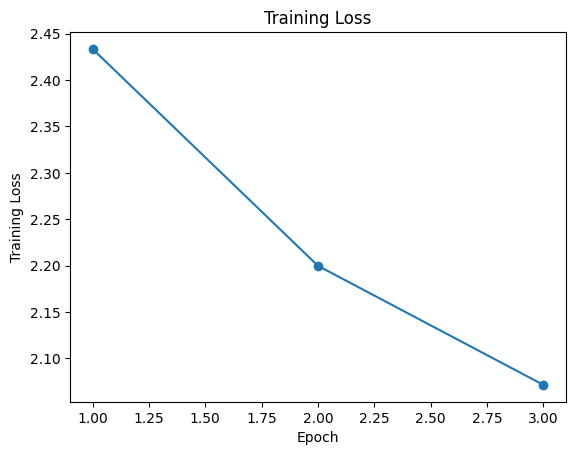

No validation losses to plot for dapt.
Domain-adapted model saved to: ./dapt_model
Final target training samples (subtask-1 only): 39014


Casting the dataset:   0%|          | 0/39014 [00:00<?, ? examples/s]

Map:   0%|          | 0/39014 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./dapt_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Target training samples: 31211
Target validation samples: 7803


A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Starting Phase 1 fine-tuning (classifier head only) ...


Epoch,Training Loss,Validation Loss,Macro F1
1,0.038200,0.037263,0.448250
2,0.037500,0.036780,0.517182
3,0.036900,0.036565,0.529027
4,0.036700,0.036437,0.557137
5,0.037000,0.036414,0.548383


Phase 1 fine-tuning complete.


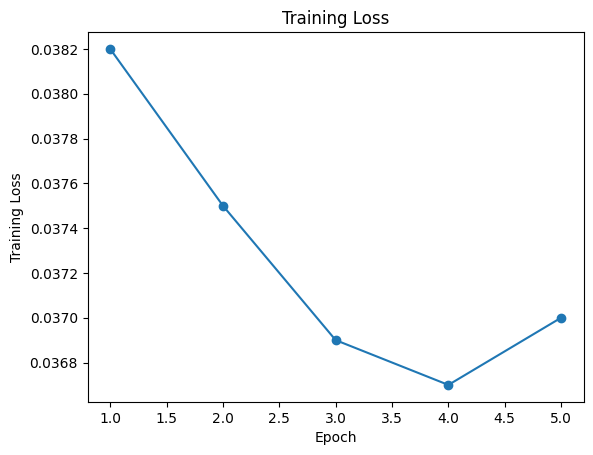

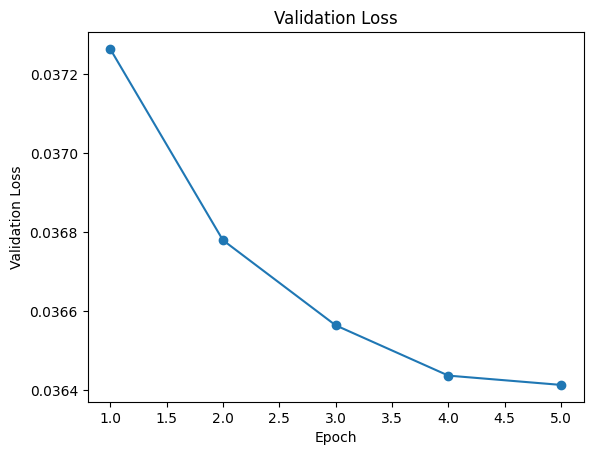

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Starting Phase 2 fine-tuning (unfreeze last 2 layers) ...


Epoch,Training Loss,Validation Loss,Macro F1
1,0.032000,0.030692,0.736595
2,0.029100,0.029402,0.749831
3,0.026500,0.028684,0.759557
4,0.024900,0.029066,0.767864
5,0.023600,0.028540,0.773802


Phase 2 fine-tuning complete.


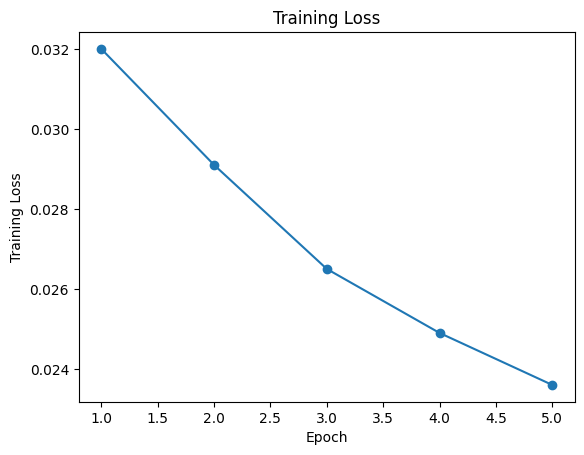

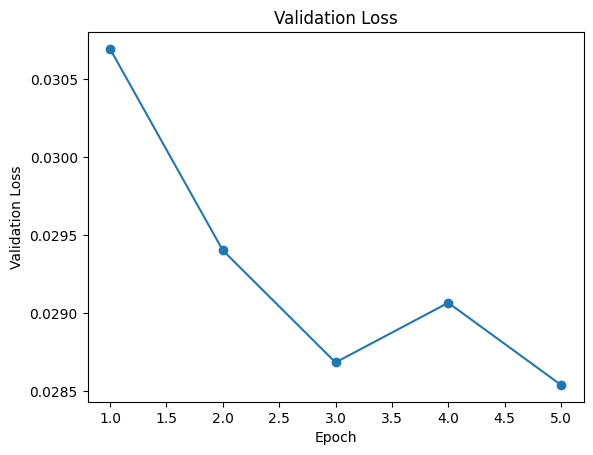

Best fine-tuned target model saved to: ./task2_model
EVALUATION on TEST DATASET

Evaluating EN test set => /kaggle/input/project-dataset/PROJECT DATASET/PROJECT DATASET/testing/test_en_l1.csv


Map:   0%|          | 0/1107 [00:00<?, ? examples/s]

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Macro-F1 for EN test set: 0.7385


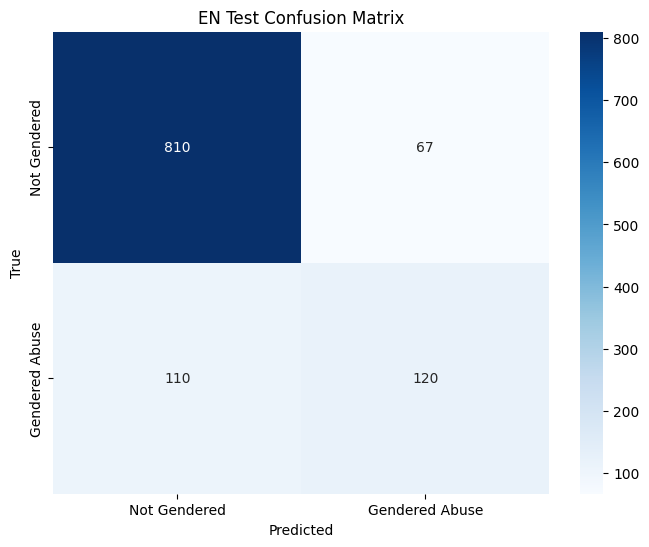

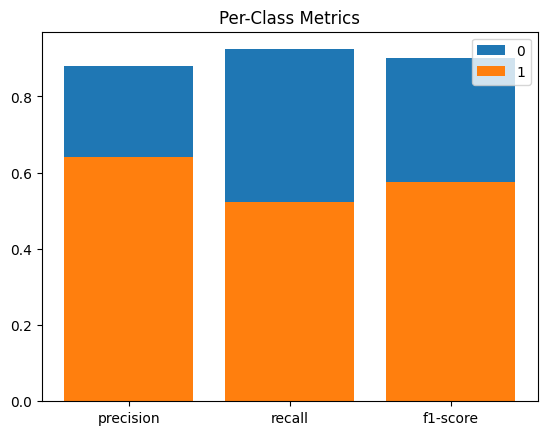


Evaluating HI test set => /kaggle/input/project-dataset/PROJECT DATASET/PROJECT DATASET/testing/test_hi_l1.csv


Map:   0%|          | 0/1516 [00:00<?, ? examples/s]

Macro-F1 for HI test set: 0.7033


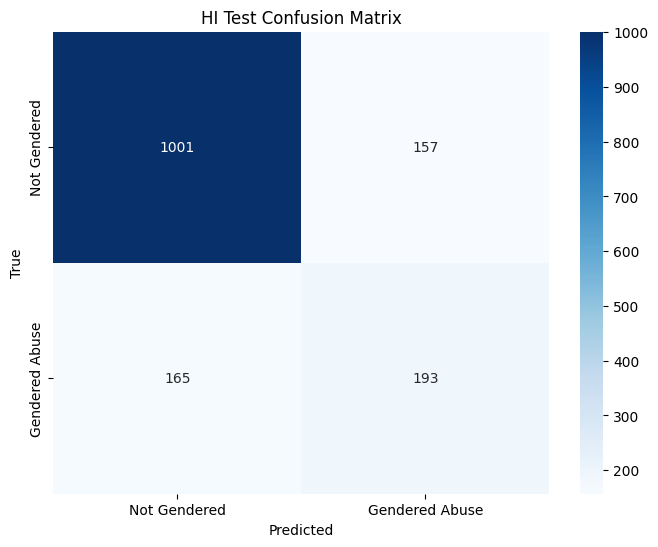

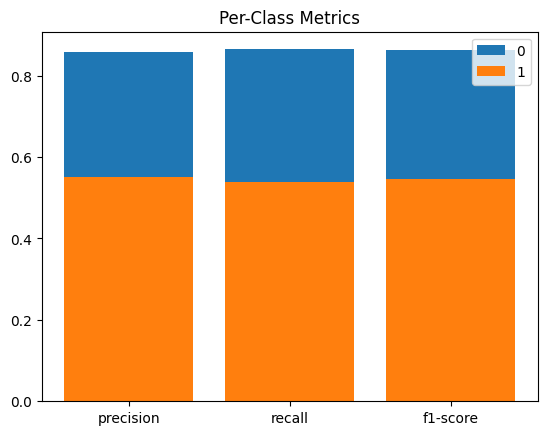


Evaluating TA test set => /kaggle/input/project-dataset/PROJECT DATASET/PROJECT DATASET/testing/test_ta_l1.csv


Map:   0%|          | 0/1135 [00:00<?, ? examples/s]

Macro-F1 for TA test set: 0.8115


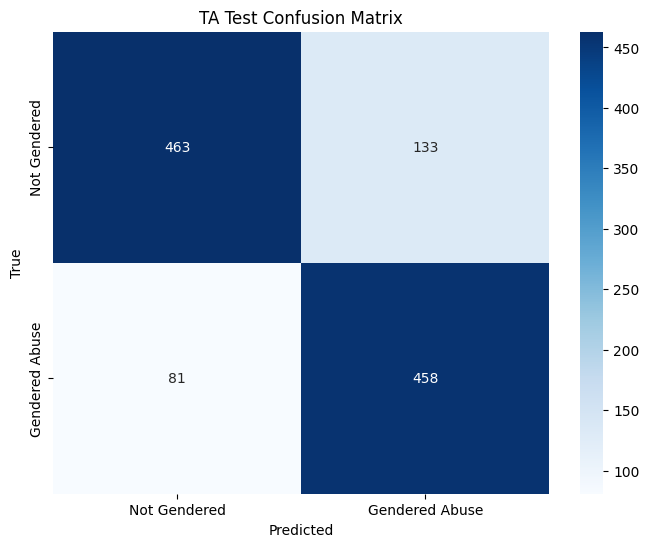

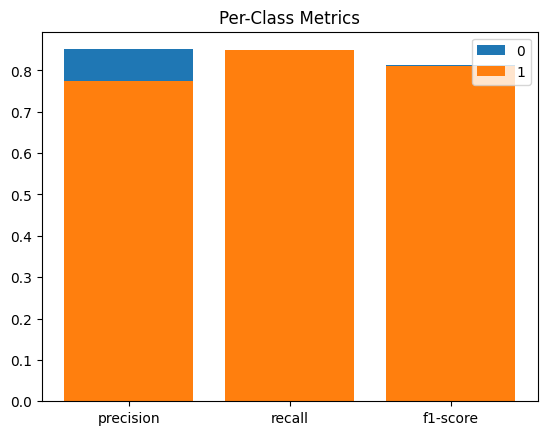


Evaluation complete. Visualizations saved.

Evaluation on test sets complete.


In [7]:
def main():
    mode_flag = "train"  
    if mode_flag == "train":
        train_task2()
        best_model_dir = "./task2_model"
        loaded_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
        temp_trainer = Trainer(model=loaded_model)
        print("EVALUATION on TEST DATASET")
        evaluate_test_sets(temp_trainer)
    elif mode_flag == "infer":
        infer_task2()
    else:
        print("Invalid mode_flag. Please set it to 'train' or 'infer'.")

if __name__ == "__main__":
    main()